In [ ]:
import os
import numpy as np
import healpy as hp
import logging

from src.utils import find_data_dirs, separate_dirs
from src.info_extractor import InfoExtractor

def normalize(data):
    return (data - np.nanmean(data, axis=0)) / np.nanstd(data, axis=0)

def exclude_outliers(data, n_sigma=5):
    normed = normalize(data)
    fine_cols= np.all(~np.isnan(normed), axis=0)
    normed = normed[:, fine_cols]
    mask = np.all(np.abs(normed) < n_sigma, axis=1)
    bad_indices = np.where(~mask)[0]
    return data[mask], bad_indices

class StatsMerger:
    def __init__(self, data_dirs, sl, ngal, opening_angle=10, zs_list=[0.5, 1.0, 1.5, 2.0, 2.5], save_dir="/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev", overwrite=False):
        self.data_dirs = data_dirs
        self.tiled_dirs, self.bigbox_dirs = separate_dirs(data_dirs)
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.overwrite = overwrite

        self.sl = sl
        self.ngal = ngal
        self.oa = opening_angle
        self.zs_list = zs_list

        self.nstats = 10
        self.nbin = 15
        self.n_sigma = 8
        self.ignore_moment = True

    def run(self):
        #self._run_and_save(is_patch=False, box_type='tiled')
        #self._run_and_save(is_patch=False, box_type='bigbox')
        self._run_and_save(is_patch=True, box_type='tiled')
        self._run_and_save(is_patch=True, box_type='bigbox')

    def _run_and_save(self, is_patch=False, box_type='tiled'):
        suffix = self._generate_suffix(is_patch)
        fname = f"fullsky_stats_{box_type}_{suffix}.npy" if not is_patch else f"patch_stats_{box_type}_{suffix}.npy"
        save_path = os.path.join(self.save_dir, f"{box_type}",fname)
        if os.path.exists(os.path.join(self.save_dir, fname)) and not self.overwrite:
            print(f"Stats file {os.path.basename(save_path)} already exists, skipping")
            return
        stats = self.merge_stats(is_patch, box_type)
        np.save(save_path, stats)
        print(f"Saved stats to {os.path.basename(save_path)}")

    def merge_stats(self, is_patch=False, box_type='tiled'):
        work_dirs = self.tiled_dirs if box_type == 'tiled' else self.bigbox_dirs
        stats = {}
        for zs in self.zs_list:
            stats_zs = []
            for data_dir in work_dirs:
                tmp_stats = self._load_stats(data_dir, zs, is_patch)
                stats_zs.append(tmp_stats)
            logging.info(f"Loaded stats for zs={zs}, merged {len(stats_zs)} stats")
            stats_zs = np.vstack(stats_zs)
            if self.ignore_moment:
                stats_zs, bad_patches = self.remove_outliers(stats_zs[:, :-7])
            else:
                stats_zs, bad_patches = self.remove_outliers(stats_zs)
            
            logging.info(f"Removed {len(bad_patches)} bad patches")
            #save bad patches
            bad_patches_path = os.path.join(self.save_dir, "bad_patches" ,f"bad_patches_{box_type}_zs{zs}_noiseless_sl{self.sl}.txt")
            if self.ngal != 0:
                bad_patches_path = bad_patches_path.replace("noiseless", f"ngal{self.ngal}")
            with open(bad_patches_path, "w") as f:
                for bp in bad_patches:
                    f.write(f"{bp}\n")
            logging.info(f"Saved bad patches to {os.path.basename(bad_patches_path)}")
            
            cov, diags, corr, stds, means = self.total_stats(stats_zs)
            stats[zs] = {
                "cov": cov,
                "diags": diags,
                "corr": corr,
                "stds": stds,
                "means": means
            }
        return stats
    
    def remove_outliers(self, data):
        bad_patches = []
        #for i in range(self.nstats):
        #    _, bad_indices = exclude_outliers(data[:, i * self.nbin:(i+1) * self.nbin], n_sigma=self.n_sigma)
        #    bad_patches.append(bad_indices)

        # only remove the cl outliers
        i = 3
        _, bad_indices = exclude_outliers(data[:, i * self.nbin:(i+1) * self.nbin], n_sigma=self.n_sigma)
        bad_patches.append(bad_indices)
        bad_patches = np.unique(np.concatenate(bad_patches))
        data = np.delete(data, bad_patches, axis=0)
        return data, bad_patches

    def total_stats(self, data):
        cov = np.cov(data, rowvar=False)
        diags = np.diag(cov)
        corr = np.corrcoef(data, rowvar=False)
        stds = np.std(data, axis=0)
        means = np.mean(data, axis=0)
        return cov, diags, corr, stds, means
    
    def _generate_suffix(self, is_patch=False):
        suffix = f"oa{self.oa}_" if is_patch else ""
        suffix += f"noiseless_sl{self.sl}"
        if self.ngal != 0:
            suffix = suffix.replace("noiseless", f"ngal{self.ngal}")
        return suffix

    def _generate_fname(self, datadir, zs, is_patch=False):
        info = InfoExtractor.extract_info_from_path(datadir)
        suffix = self._generate_suffix(is_patch)
        if is_patch:
            fname = f"analysis_zs{zs}_s{info['seed']}_{suffix}.npy"
        else:
            fname = f"fullsky_clpdpm_s{info['seed']}_zs{zs}_{suffix}.npy"
        return fname

    def _load_stats(self, data_dir, zs, is_patch=False):
        fname = self._generate_fname(data_dir, zs, is_patch)
        data = np.load(os.path.join(data_dir, "analysis_fullsky", fname)) if not is_patch else np.load(os.path.join(data_dir, "analysis_patch", fname))            
        return data
   
   

In [143]:
sm = StatsMerger(find_data_dirs(), sl=2, ngal=0, overwrite=True)
for ngal in [0, 7, 15, 30, 50]:
    for sl in [2, 5, 8, 10]:
        sm.sl = sl
        sm.ngal = ngal
        sm.run()

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Saved stats to patch_stats_tiled_oa10_noiseless_sl2.npy
Saved stats to patch_stats_bigbox_oa10_noiseless_sl2.npy
Saved stats to patch_stats_tiled_oa10_noiseless_sl5.npy
Saved stats to patch_stats_bigbox_oa10_noiseless_sl5.npy
Saved stats to patch_stats_tiled_oa10_noiseless_sl8.npy
Saved stats to patch_stats_bigbox_oa10_noiseless_sl8.npy
Saved stats to patch_stats_tiled_oa10_noiseless_sl10.npy
Saved stats to patch_stats_bigbox_oa10_noiseless_sl10.npy
Saved stats to patch_stats_tiled_oa10_ngal7_sl2.npy
Saved stats to patch_stats_bigbox_oa10_ngal7_sl2.npy
Saved stats to patch_stats_tiled_oa10_ngal7_sl5.npy
Saved stats to patch_stats_bigbox_oa10_ngal7_sl5.npy
Saved stats to patch_stats_tiled_oa10_ngal7_sl8.npy
Saved stats to patch_stats_bigbox_oa10_ngal7_sl8.npy
Saved stats to patch_stats_tiled_oa10_ngal7_sl10.npy
Saved stats to patch_stats_bigbox_oa10_ngal7_sl10.npy
Saved stats to patch_stats_tiled_oa10_ngal15_sl2.npy
Saved stats to patch_stats_bigbox_oa10_ngal15_sl2.npy
Saved stats to pa

In [144]:
statfile_tiled = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev/tiled/patch_stats_tiled_oa10_noiseless_sl2.npy"
statfile_bigbox = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev/bigbox/patch_stats_bigbox_oa10_noiseless_sl2.npy"

stats_tiled = np.load(statfile_tiled, allow_pickle=True).item()
stats_bigbox = np.load(statfile_bigbox, allow_pickle=True).item()

In [147]:
file2 = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev/tiled/patch_stats_tiled_oa10_noiseless_sl2.npy"
file5 = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev/tiled/patch_stats_tiled_oa10_noiseless_sl5.npy"
file8 = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev/tiled/patch_stats_tiled_oa10_noiseless_sl8.npy"
file10 = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev/tiled/patch_stats_tiled_oa10_noiseless_sl10.npy"

stats2 = np.load(file2, allow_pickle=True).item()
stats5 = np.load(file5, allow_pickle=True).item()
stats8 = np.load(file8, allow_pickle=True).item()
stats10 = np.load(file10, allow_pickle=True).item()


In [150]:
stats = [stats2, stats5, stats8, stats10]

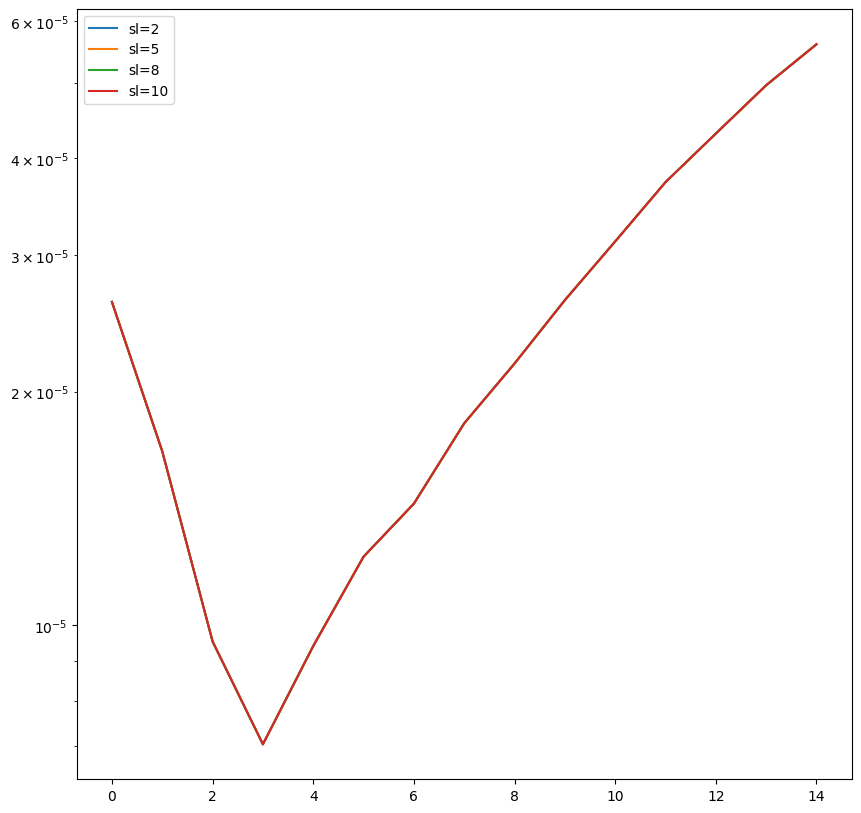

In [157]:
# compare the means of the stats
zs = 1.5

fig = plt.figure(figsize=(10, 10))
for i, sl in enumerate([2, 5, 8, 10]):
    means = stats[i][zs]["means"][30:45]
    plt.plot(means, label=f"sl={sl}")
plt.yscale("log")
plt.legend()
plt.show()


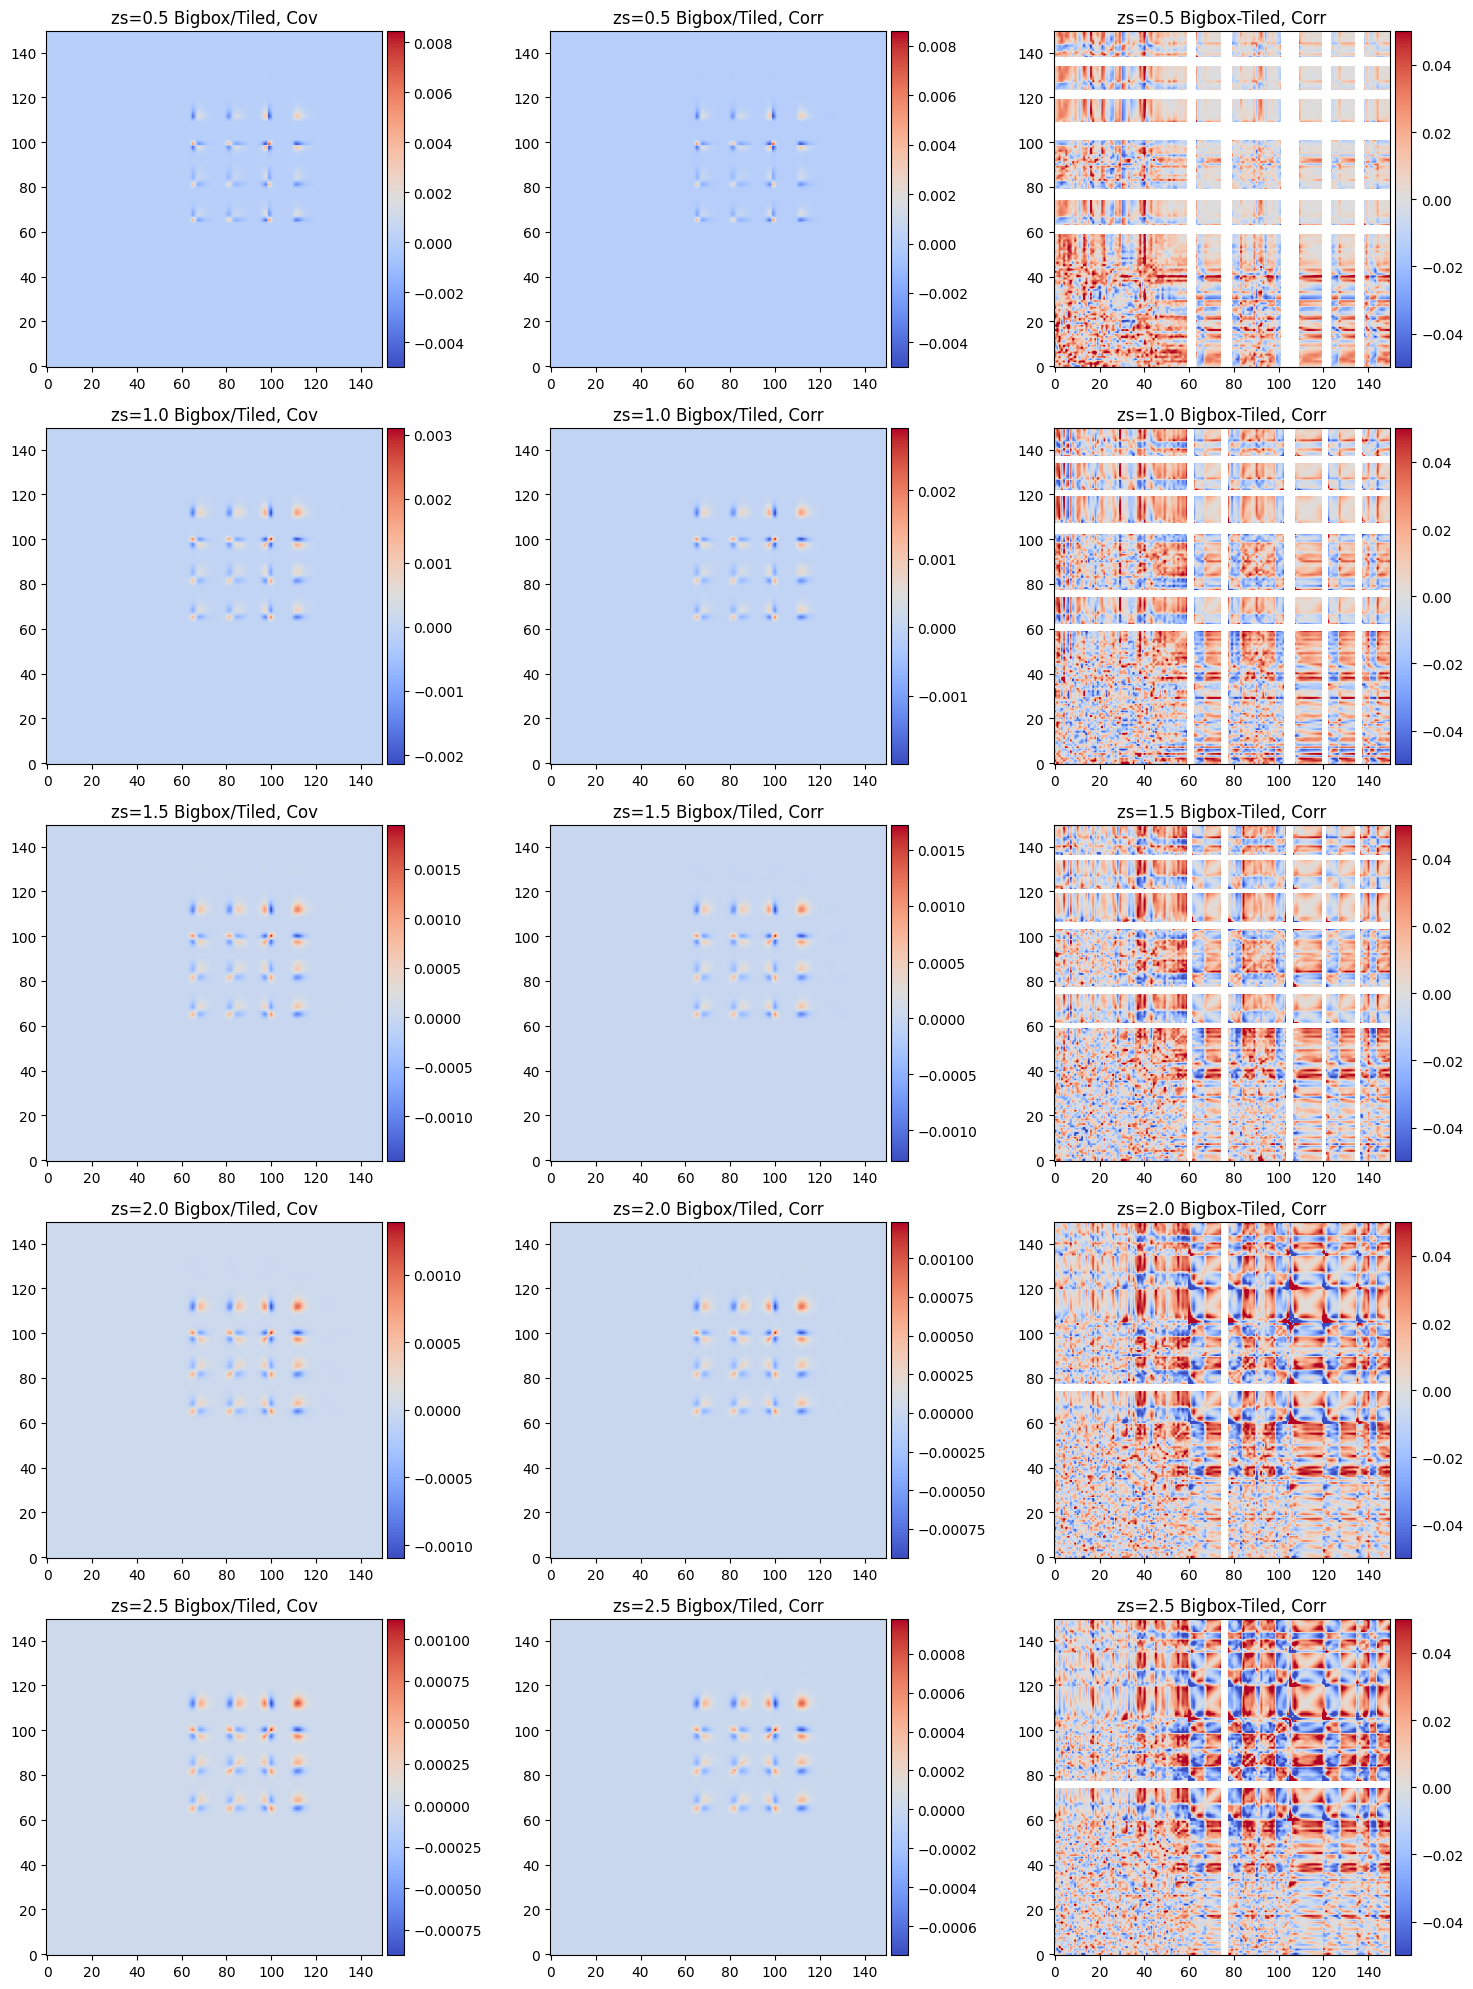

In [145]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

zs_list = [0.5, 1.0, 1.5, 2.0, 2.5]

fig, axes = plt.subplots(5, 3, figsize=(15, 20))
for i, zs in enumerate(zs_list):
    im = axes[i, 0].imshow(stats_bigbox[zs]["cov"], origin="lower",  cmap="coolwarm")
    divider = make_axes_locatable(axes[i, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axes[i, 1].imshow(stats_tiled[zs]["cov"], origin="lower", cmap="coolwarm")
    divider = make_axes_locatable(axes[i, 1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axes[i, 2].imshow(stats_bigbox[zs]["corr"]-stats_tiled[zs]["corr"], origin="lower", vmin=-0.05, vmax=0.05, cmap="coolwarm")
    divider = make_axes_locatable(axes[i, 2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    axes[i, 0].set_title(f"zs={zs} Bigbox/Tiled, Cov")
    axes[i, 1].set_title(f"zs={zs} Bigbox/Tiled, Corr")
    axes[i, 2].set_title(f"zs={zs} Bigbox-Tiled, Corr")
plt.tight_layout()
plt.show()

/var/tmp/pbs.306416.idark/ipykernel_81992/1480564545.py:4: RuntimeWarning: invalid value encountered in true_divide
  axes[i//5, i%5].plot(stats_bigbox[zs]["diags"][15*i:15*(i+1)]/stats_tiled[zs]["diags"][15*i:15*(i+1)], label=f"zs={zs}")


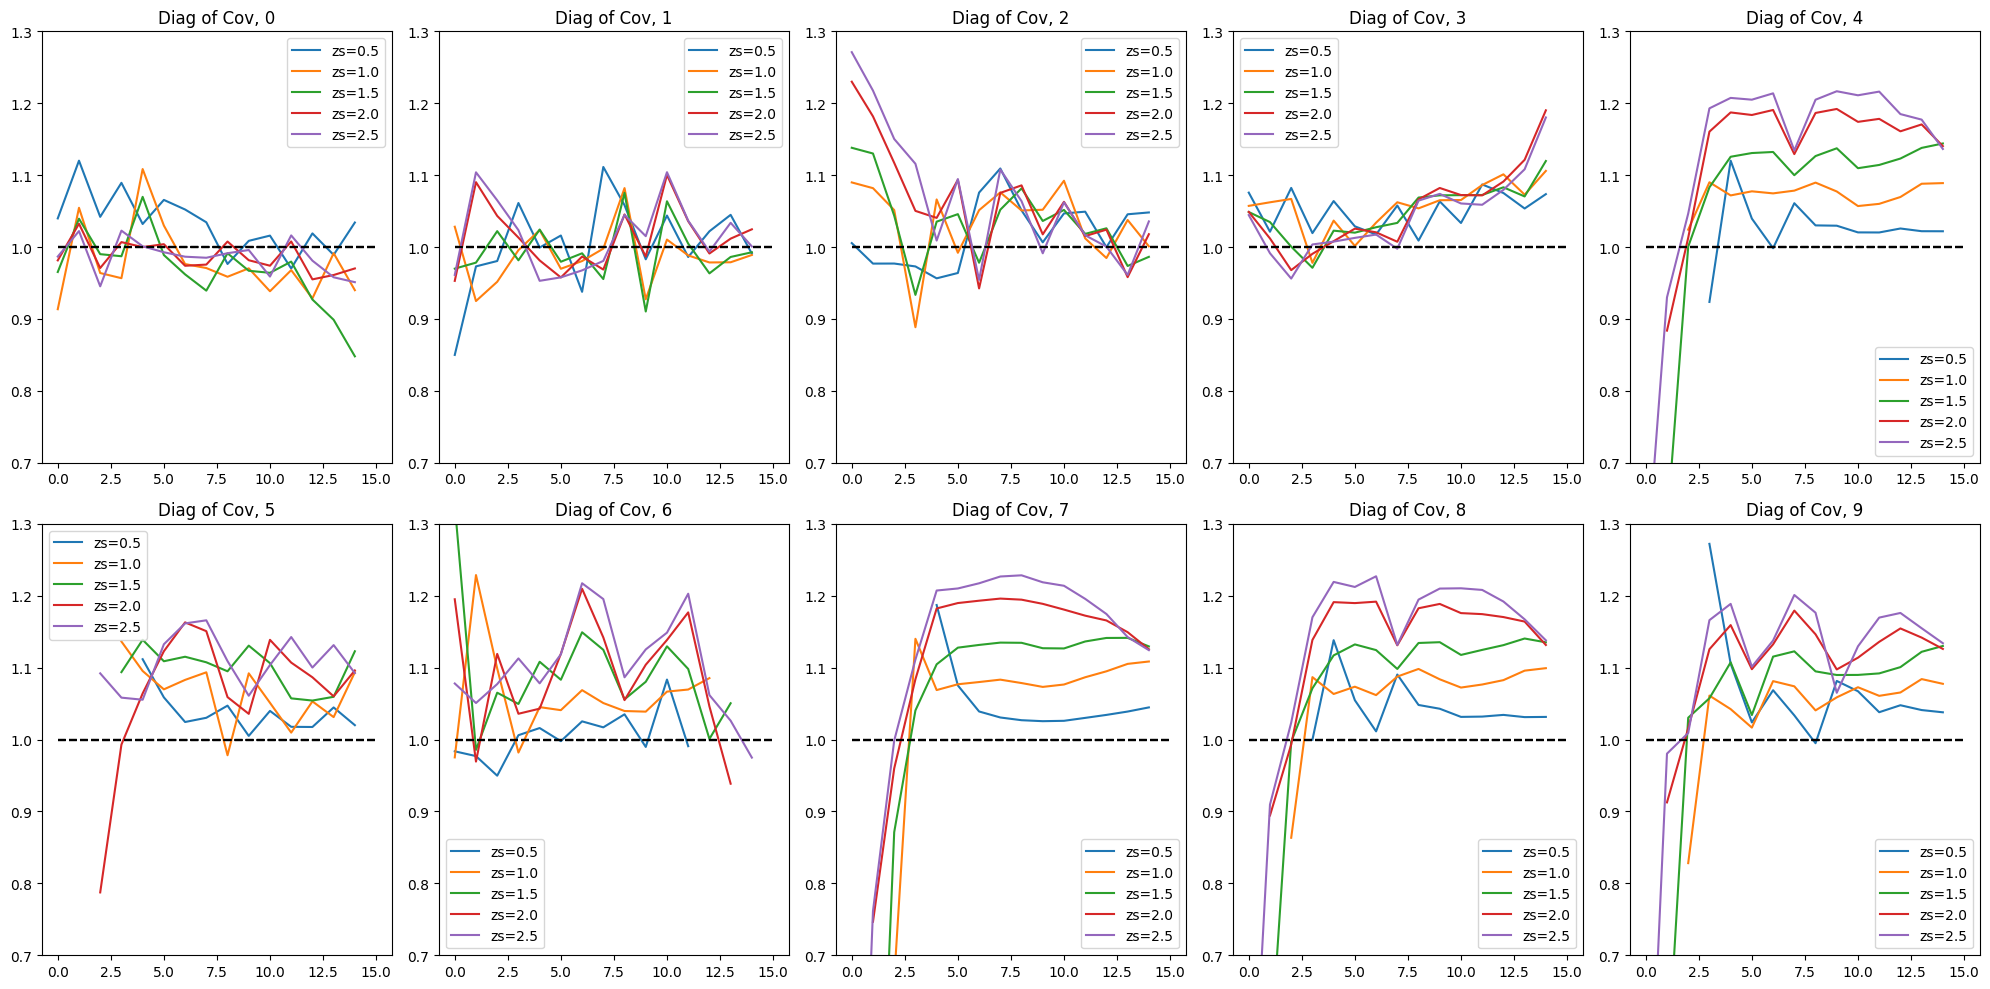

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    for zs in zs_list:
        axes[i//5, i%5].plot(stats_bigbox[zs]["diags"][15*i:15*(i+1)]/stats_tiled[zs]["diags"][15*i:15*(i+1)], label=f"zs={zs}")
        axes[i//5, i%5].hlines(1, 0, 15, linestyle="--", color="black")
        axes[i//5, i%5].set_title(f"Diag of Cov, {i}")
        axes[i//5, i%5].legend()
        axes[i//5, i%5].set_ylim(0.7, 1.3)
plt.tight_layout()
plt.show()

/var/tmp/pbs.306416.idark/ipykernel_81992/376099071.py:4: RuntimeWarning: invalid value encountered in true_divide
  axes[i//5, i%5].plot(stats_bigbox[zs]["means"][15*i:15*(i+1)]/stats_tiled[zs]["means"][15*i:15*(i+1)], label=f"zs={zs}")


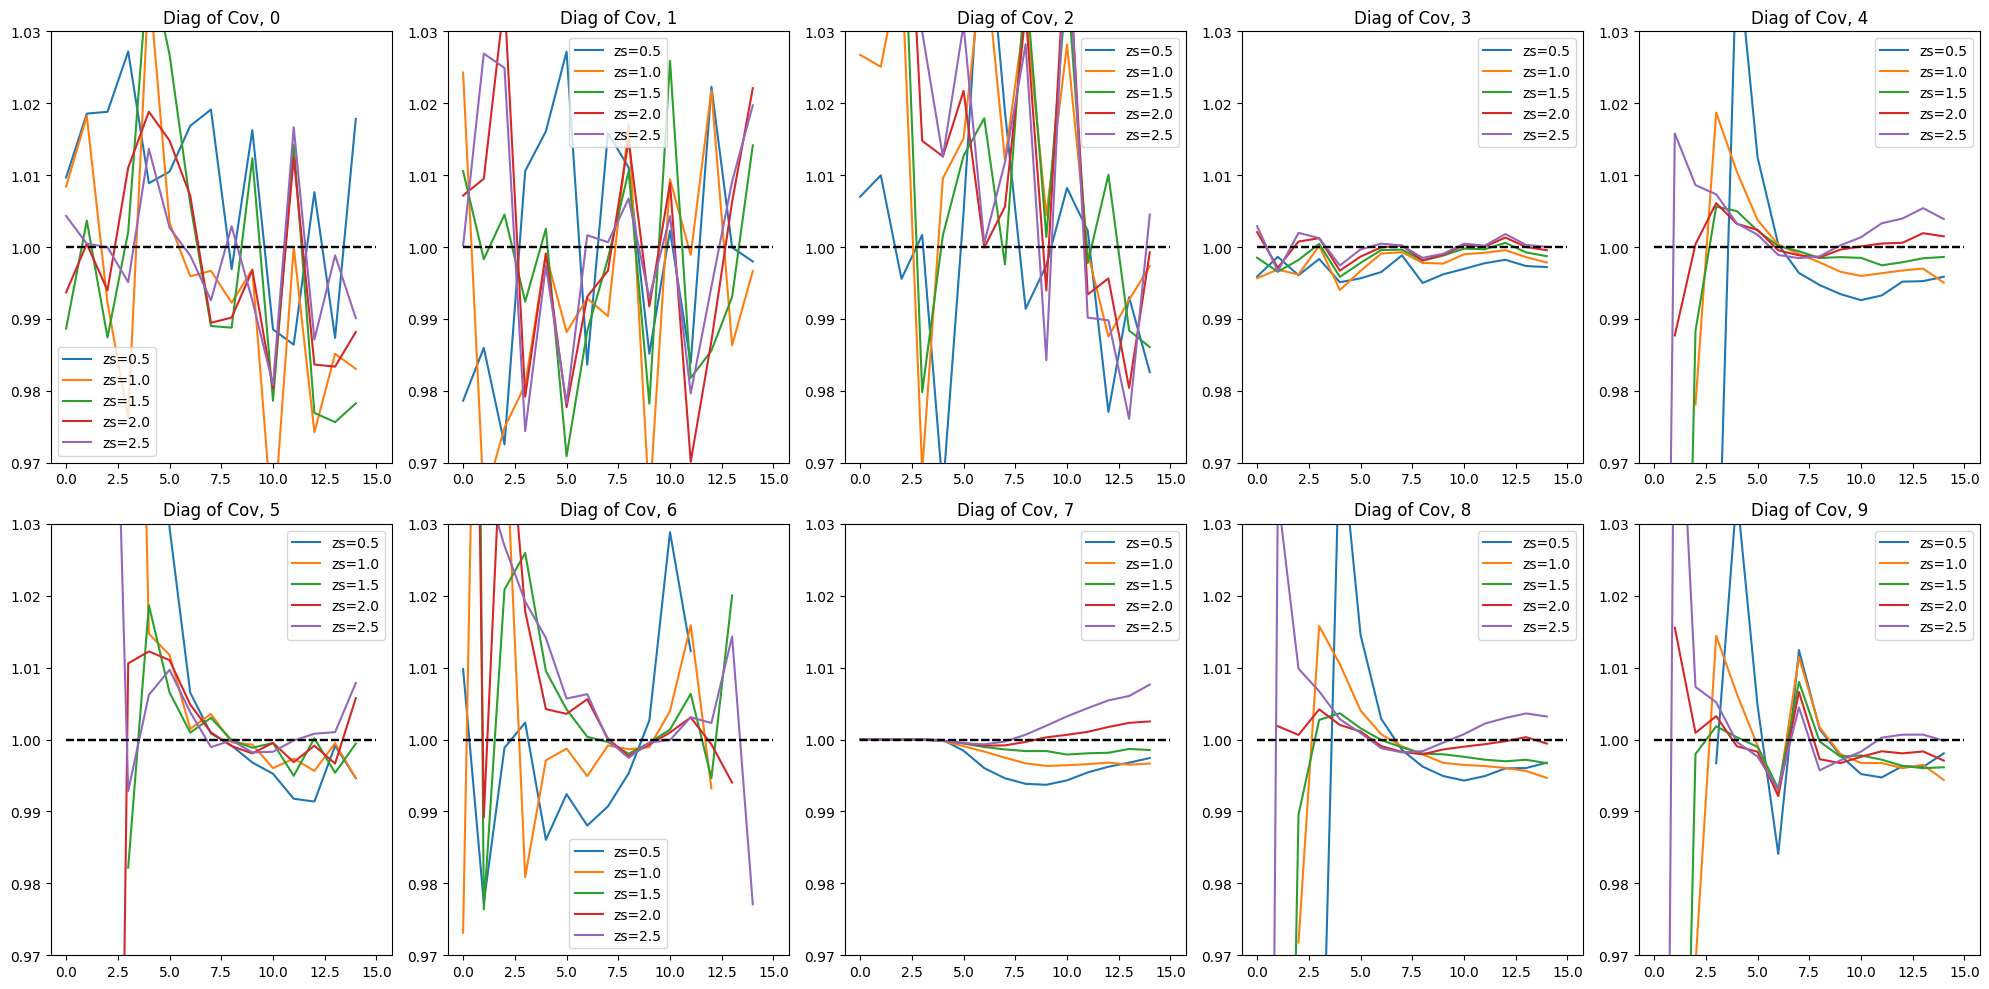

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    for zs in zs_list:
        axes[i//5, i%5].plot(stats_bigbox[zs]["means"][15*i:15*(i+1)]/stats_tiled[zs]["means"][15*i:15*(i+1)], label=f"zs={zs}")
        axes[i//5, i%5].hlines(1, 0, 15, linestyle="--", color="black")
        axes[i//5, i%5].set_title(f"Diag of Cov, {i}")
        axes[i//5, i%5].legend()
        axes[i//5, i%5].set_ylim(0.97, 1.03)
plt.tight_layout()
plt.show()

/var/tmp/pbs.306416.idark/ipykernel_81992/3317988076.py:4: RuntimeWarning: invalid value encountered in true_divide
  axes[i//5, i%5].plot(stats_bigbox[zs]["stds"][15*i:15*(i+1)]/stats_tiled[zs]["stds"][15*i:15*(i+1)], label=f"zs={zs}")


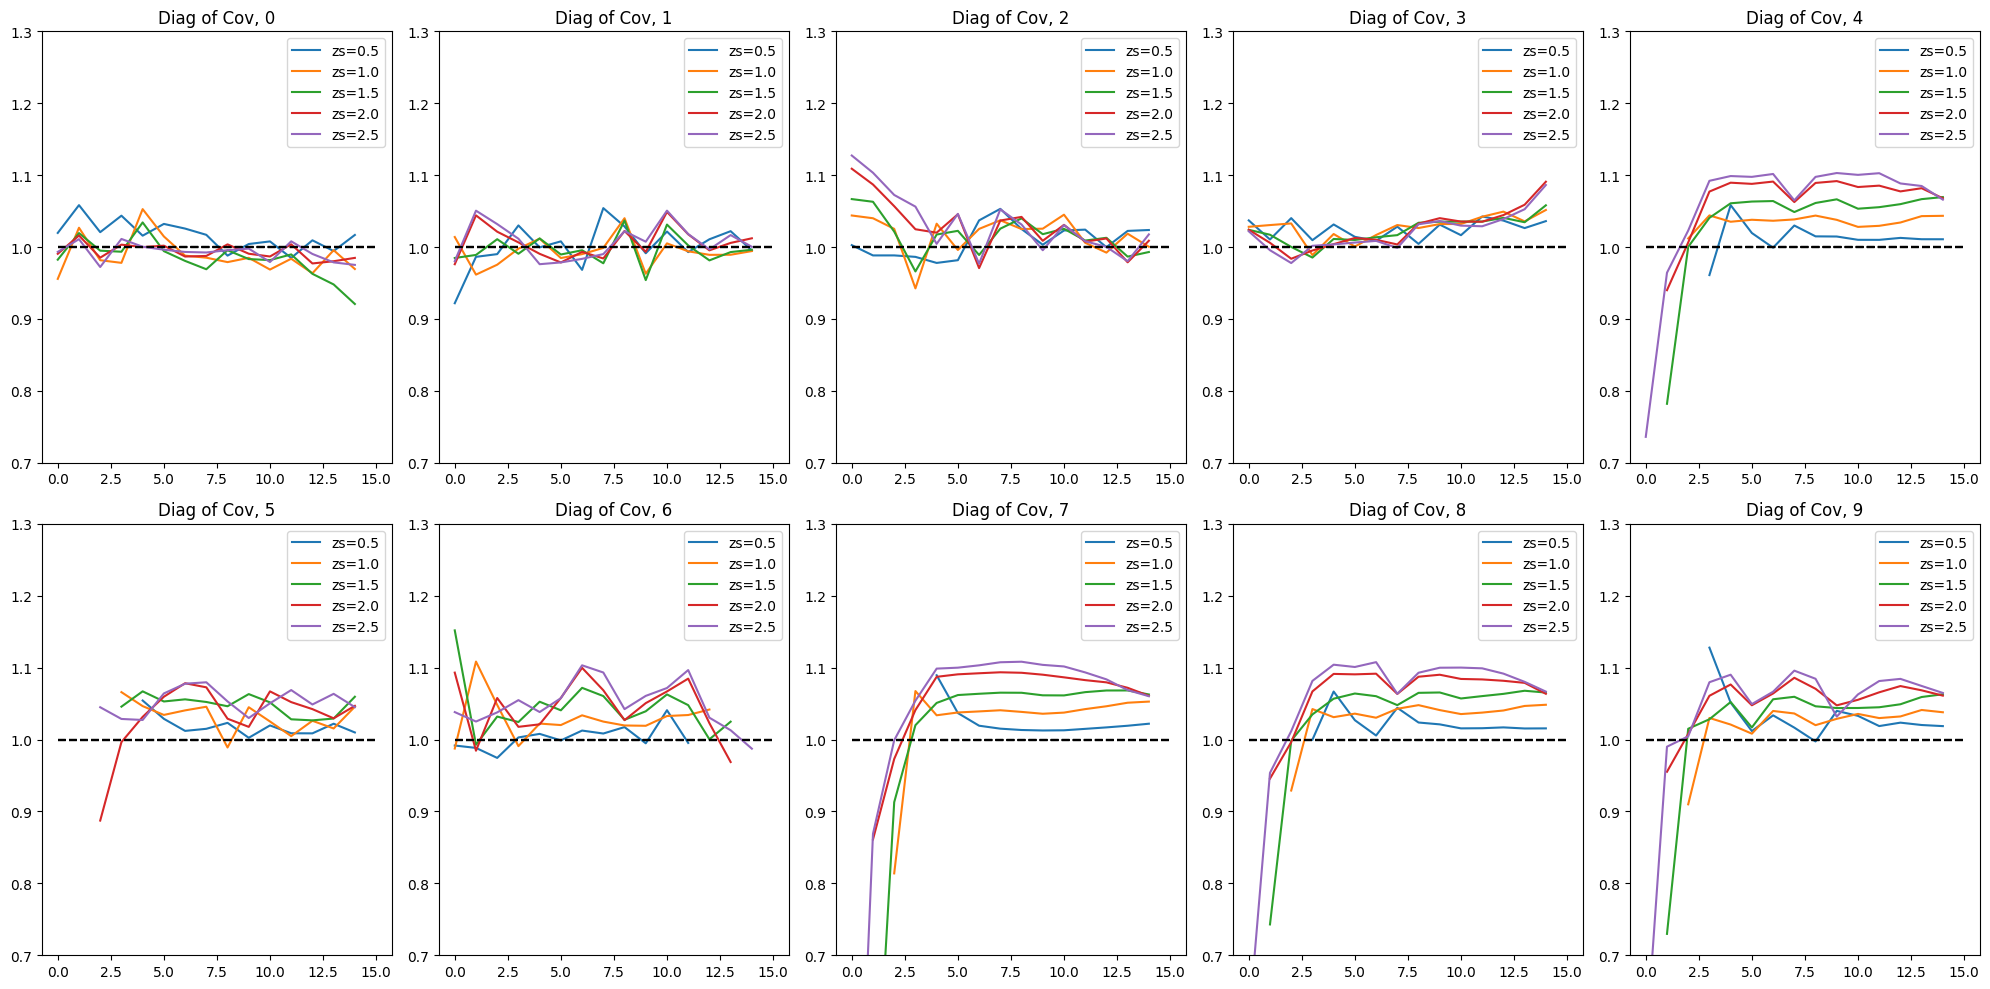

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    for zs in zs_list:
        axes[i//5, i%5].plot(stats_bigbox[zs]["stds"][15*i:15*(i+1)]/stats_tiled[zs]["stds"][15*i:15*(i+1)], label=f"zs={zs}")
        axes[i//5, i%5].hlines(1, 0, 15, linestyle="--", color="black")
        axes[i//5, i%5].set_title(f"Diag of Cov, {i}")
        axes[i//5, i%5].legend()
        axes[i//5, i%5].set_ylim(0.7, 1.3)
plt.tight_layout()
plt.show()

In [1]:
import h5py

def load_results_from_hdf5(hdf5_path):
    """
    Loads the results from an HDF5 file into a nested dictionary.
    
    Parameters:
    - hdf5_path (str or Path): Path to the HDF5 file.
    
    Returns:
    - results (dict): Nested dictionary mirroring the original structure.
    """
    results = {}
    with h5py.File(hdf5_path, 'r') as hf:
        for ngal_key in hf.keys():
            # Extract 'ngal' value from group name
            ngal = int(ngal_key.replace('ngal_', ''))
            results[ngal] = {}
            ngal_group = hf[ngal_key]
            
            # Load 'cl', 'equilateral', 'isosceles', 'squeezed'
            for key in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                if key in ngal_group:
                    results[ngal][key] = np.array(ngal_group[key])
            
            # Iterate over 'sl' groups
            for sl_key in ngal_group.keys():
                if sl_key.startswith('sl_'):
                    sl = int(sl_key.replace('sl_', ''))
                    results[ngal][sl] = {}
                    sl_group = ngal_group[sl_key]
                    
                    for sub_key in ['pdf', 'peaks', 'minima', 'v0', 'v1', 'v2', 'sigma0', 'sigma1']:
                        if sub_key in sl_group:
                            results[ngal][sl][sub_key] = np.array(sl_group[sub_key])
    return results

In [2]:
import os
import glob
import logging
import numpy as np
import multiprocessing as mp
import h5py
from pathlib import Path

# Assuming separate_dirs and InfoExtractor are defined elsewhere
# from your_module import separate_dirs, InfoExtractor

class StatsMerger:
    def __init__(
        self,
        tiled_dirs,
        bigbox_dirs,
        sl,
        ngal,
        opening_angle=10,
        zs_list=[0.5, 1.0, 1.5, 2.0, 2.5],
        save_dir="/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev",
        overwrite=False
    ):
        """
        Initializes the StatsMerger.

        Parameters:
        - data_dirs (list of str): Directories containing 'tiled' and 'bigbox' subdirectories.
        - sl (int or float): Specific sl value.
        - ngal (int): Specific ngal value.
        - opening_angle (int, optional): Opening angle parameter. Default is 10.
        - zs_list (list of float, optional): List of zs values. Default is [0.5, 1.0, 1.5, 2.0, 2.5].
        - save_dir (str, optional): Base directory to save merged stats. Default is specified path.
        - overwrite (bool, optional): Whether to overwrite existing files. Default is False.
        """
        self.tiled_dirs = tiled_dirs
        self.bigbox_dirs = bigbox_dirs
        self.save_dir = Path(save_dir)
        os.makedirs(self.save_dir, exist_ok=True)
        self.overwrite = overwrite

        self.sl = sl
        self.ngal = ngal
        self.oa = opening_angle
        self.zs_list = zs_list

        self.nstats = 10
        self.nbin = 15
        self.n_sigma = 8
        self.ignore_moment = True

    def run(self):
        """
        Executes the merging and saving process for both 'tiled' and 'bigbox' datasets.
        """
        # Uncomment the desired processing modes
        # self._run_and_save(is_patch=False, box_type='tiled')
        # self._run_and_save(is_patch=False, box_type='bigbox')
        self._run_and_save(is_patch=True, box_type='tiled')
        self._run_and_save(is_patch=True, box_type='bigbox')

    def _run_and_save(self, is_patch=False, box_type='tiled'):
        """
        Merges stats for a given box type and saves them to an HDF5 file.

        Parameters:
        - is_patch (bool): Whether the stats are patch-based.
        - box_type (str): Type of the box ('tiled' or 'bigbox').
        """
        suffix = self._generate_suffix(is_patch)
        fname = f"fullsky_stats_{box_type}_{suffix}.h5" if not is_patch else f"patch_stats_{box_type}_{suffix}.h5"
        save_path = self.save_dir / box_type / fname

        if save_path.exists() and not self.overwrite:
            logging.info(f"Stats file {save_path.name} already exists, skipping")
            return

        stats = self.merge_stats(is_patch, box_type)
        if stats:  # Proceed only if stats is not empty
            self.save_results_to_hdf5(stats, save_path)
            logging.info(f"Saved stats to {save_path}")
        else:
            logging.warning(f"No stats to save for {box_type} with suffix {suffix}")

    def merge_stats(self, is_patch=False, box_type='tiled'):
        """
        Merges statistics from multiple HDF5 files for a given box type and zs.

        Parameters:
        - is_patch (bool): Whether the stats are patch-based.
        - box_type (str): Type of the box ('tiled' or 'bigbox').

        Returns:
        - stats (dict): Nested dictionary containing merged statistics per zs.
        """
        work_dirs = self.tiled_dirs if box_type == 'tiled' else self.bigbox_dirs
        stats = {}
        for zs in self.zs_list:
            stats_zs = []
            for data_dir in work_dirs:
                tmp_stats = self._load_stats(data_dir, zs, is_patch)
                if tmp_stats.size > 0:
                    stats_zs.append(tmp_stats)
            if not stats_zs:
                logging.warning(f"No stats found for zs={zs} in box_type={box_type}. Skipping.")
                continue
            logging.info(f"Loaded stats for zs={zs}, merged {len(stats_zs)} stats")
            stats_zs = np.vstack(stats_zs)
            stats_zs, bad_patches = self.remove_outliers(stats_zs)

            logging.info(f"Removed {len(bad_patches)} bad patches")
            # Save bad patches
            bad_patches_path = self.save_dir / "bad_patches" / f"bad_patches_{box_type}_zs{zs}_noiseless_sl{self.sl}.txt"
            if self.ngal != 0:
                bad_patches_path = bad_patches_path.parent / bad_patches_path.name.replace("noiseless", f"ngal{self.ngal}")
            bad_patches_path.parent.mkdir(parents=True, exist_ok=True)
            with open(bad_patches_path, "w") as f:
                for bp in bad_patches:
                    f.write(f"{bp}\n")
            logging.info(f"Saved bad patches to {bad_patches_path.name}")

            cov, diags, corr, stds, means = self.total_stats(stats_zs)
            stats[zs] = {
                "cov": cov,
                "diags": diags,
                "corr": corr,
                "stds": stds,
                "means": means
            }
        return stats

    def remove_outliers(self, data):
        """
        Removes outliers from the data based on the specified sigma threshold.

        Parameters:
        - data (np.ndarray): Data array from which to remove outliers.

        Returns:
        - data (np.ndarray): Cleaned data array.
        - bad_patches (np.ndarray): Indices of patches identified as outliers.
        """
        bad_patches = []
        for i in range(self.nstats):
            _, bad_indices = exclude_outliers(data[:, i * self.nbin:(i + 1) * self.nbin], n_sigma=self.n_sigma)
            bad_patches.append(bad_indices)
        bad_patches = np.unique(np.concatenate(bad_patches))
        if bad_patches.size > 0:
            data = np.delete(data, bad_patches, axis=0)
        return data, bad_patches

    def total_stats(self, data):
        """
        Computes total statistics from the merged data.

        Parameters:
        - data (np.ndarray): Merged data array after outlier removal.

        Returns:
        - cov (np.ndarray): Covariance matrix.
        - diags (np.ndarray): Diagonal elements of the covariance matrix.
        - corr (np.ndarray): Correlation matrix.
        - stds (np.ndarray): Standard deviations.
        - means (np.ndarray): Means.
        """
        cov = np.cov(data, rowvar=False)
        diags = np.diag(cov)
        corr = np.corrcoef(data, rowvar=False)
        stds = np.std(data, axis=0)
        means = np.mean(data, axis=0)
        return cov, diags, corr, stds, means

    def _generate_suffix(self, is_patch=False):
        """
        Generates a suffix for filenames based on whether the stats are patch-based.

        Parameters:
        - is_patch (bool): Whether the stats are patch-based.

        Returns:
        - suffix (str): Generated suffix string.
        """
        suffix = f"oa{self.oa}_" if is_patch else ""
        suffix += f"noiseless_sl{self.sl}"
        if self.ngal != 0:
            suffix = suffix.replace("noiseless", f"ngal{self.ngal}")
        return suffix

    def _generate_fname(self, datadir, zs, is_patch=False):
        """
        Generates the filename for a given data directory, zs value, and patch status.

        Parameters:
        - datadir (str): Directory containing the stats files.
        - zs (float): Specific zs value.
        - is_patch (bool): Whether the stats are patch-based.

        Returns:
        - fname (str): Generated filename.
        """
        info = InfoExtractor.extract_info_from_path(datadir)
        suffix = self._generate_suffix(is_patch)
        if is_patch:
            fname = f"stats_zs{zs}_s{info['seed']}_oa{self.oa}.h5"
        else:
            fname = f"fullsky_stats_zs{zs}_s{info['seed']}_oa{self.oa}.h5"
        return fname

    def _load_stats(self, data_dir, zs, is_patch=False):
        """
        Loads stats from a specific HDF5 file.

        Parameters:
        - data_dir (str): Directory containing the stats files.
        - zs (float): Specific zs value.
        - is_patch (bool): Whether the stats are patch-based.

        Returns:
        - data (np.ndarray): Loaded stats data array.
        """
        fname = self._generate_fname(data_dir, zs, is_patch)
        if not is_patch:
            load_path = Path(data_dir) / "stats" / fname
        else:
            load_path = Path(data_dir) / "stats" / fname

        if not load_path.exists():
            logging.warning(f"File {load_path} does not exist. Skipping.")
            return np.array([])  # Return empty array if file doesn't exist

        try:
            with h5py.File(load_path, 'r') as hf:
                # Assuming each HDF5 file contains a dataset named 'stats'
                if 'stats' in hf:
                    data = hf['stats'][:]
                    logging.debug(f"Loaded data from {load_path}")
                    return data
                else:
                    logging.error(f"'stats' dataset not found in {load_path}. Skipping.")
                    return np.array([])
        except Exception as e:
            logging.error(f"Error reading {load_path}: {e}")
            return np.array([])

    def save_results_to_hdf5(self, results, save_path):
        """
        Saves the results dictionary to an HDF5 file.

        Parameters:
        - results (dict): Nested dictionary containing the results.
        - save_path (Path): Path object indicating where to save the HDF5 file.
        """
        try:
            with h5py.File(save_path, 'w') as hf:
                for zs, zs_data in results.items():
                    logging.info(f"Saving data for zs={zs}")
                    zs_group = hf.create_group(f"zs_{zs}")

                    # Save 'cov', 'diags', 'corr', 'stds', 'means'
                    for key in ['cov', 'diags', 'corr', 'stds', 'means']:
                        if key in zs_data:
                            data = zs_data[key]
                            if isinstance(data, np.ndarray) and np.issubdtype(data.dtype, np.number):
                                zs_group.create_dataset(
                                    key,
                                    data=data.astype(np.float32),  # Ensure numeric dtype
                                    compression="gzip",
                                    compression_opts=4
                                )
                                # Optionally, add attributes
                                zs_group[key].attrs['description'] = f"{key} for zs={zs}"
                            else:
                                logging.error(f"Data for {key} in zs={zs} is not a numeric NumPy array. Skipping.")
            logging.info(f"Successfully saved results to {save_path}")
        except Exception as e:
            logging.error(f"Failed to save results to {save_path}: {e}")
            raise


In [112]:
tiled_dirs = list(Path("/lustre/work/akira.tokiwa/Projects/LensingSSC/output").glob("tiled/stats/*.h5"))
bigbox_dirs = list(Path("/lustre/work/akira.tokiwa/Projects/LensingSSC/output").glob("bigbox/stats/*.h5"))

In [113]:
def create_empty_results(tiled_dirs):
    results = load_results_from_hdf5(tiled_dirs[0])
    new_results = {}
    for ngal in results.keys():
        new_results[ngal] = {}
        for sl in results[ngal].keys():
            new_results[ngal][sl] = {}
            if sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                new_results[ngal][sl] = []
            else:
                for key in results[ngal][sl].keys():
                    new_results[ngal][sl][key] = []
    return new_results

def insert_stats(tiled_dirs):
    results = create_empty_results(tiled_dirs)
    for tiled_dir in tiled_dirs:
        stats = load_results_from_hdf5(tiled_dir)
        for ngal in stats.keys():
            for sl in stats[ngal].keys():
                if sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                    results[ngal][sl].append(stats[ngal][sl])
                else:
                    for key in stats[ngal][sl].keys():
                        results[ngal][sl][key].append(stats[ngal][sl][key])

    for ngal in results.keys():
        for sl in results[ngal].keys():
            if sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                results[ngal][sl] = np.concatenate(results[ngal][sl], axis=0)
            else:
                for key in results[ngal][sl].keys():
                    results[ngal][sl][key] = np.concatenate(results[ngal][sl][key], axis=0)
    return results

In [114]:
def create_empty_merged_stats(tiled_dirs, zs_list=[0.5, 1.0, 1.5, 2.0, 2.5]):
    desired_stats = ['cov', 'diags', 'corr', 'stds', 'means']
    results = load_results_from_hdf5(tiled_dirs[0])
    new_results = {}
    for zs in zs_list:
        new_results[zs] = {}
        for ngal in results.keys():
            new_results[zs][ngal] = {}
            new_results[zs][ngal]["combined_correlation"] = []
            for sl in results[ngal].keys():
                new_results[zs][ngal][sl] = {}
                if sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                    new_results[zs][ngal][sl] = {}
                    for stat in desired_stats:
                        new_results[zs][ngal][sl][stat] = []
                else:
                    new_results[zs][ngal][sl]["combined_nonlinear"] = []
                    for key in results[ngal][sl].keys():
                        new_results[zs][ngal][sl][key] = {}
                        for stat in desired_stats:
                            new_results[zs][ngal][sl][key][stat] = []
    return new_results


def calculate_merged_stats(tiled_dirs, bigbox_dirs, zs_list):
    merged_stats_tiled = create_empty_merged_stats(tiled_dirs, zs_list)
    merged_stats_bigbox = create_empty_merged_stats(bigbox_dirs, zs_list)
    for zs in zs_list:
        tiled_dirs_zs = [str(p) for p in tiled_dirs if f"zs{zs}" in p.name]
        bigbox_dirs_zs = [str(p) for p in bigbox_dirs if f"zs{zs}" in p.name]

        stats_tiled = insert_stats(tiled_dirs_zs)
        stats_bigbox = insert_stats(bigbox_dirs_zs)

        for ngal in stats_tiled.keys():
            for sl in stats_tiled[ngal].keys():
                if sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                    merged_stats_tiled[zs][ngal]["combined_correlation"].append(stats_tiled[ngal][sl])
                    merged_stats_bigbox[zs][ngal]["combined_correlation"].append(stats_bigbox[ngal][sl])
                    for stat in ['cov', 'diags', 'corr', 'stds', 'means']:
                        merged_stats_tiled[zs][ngal][sl][stat] = compute_stats(stats_tiled[ngal][sl], stat)
                        merged_stats_bigbox[zs][ngal][sl][stat] = compute_stats(stats_bigbox[ngal][sl], stat)
                else:
                    for key in stats_tiled[ngal][sl].keys():
                        merged_stats_tiled[zs][ngal][sl]["combined_nonlinear"].append(stats_tiled[ngal][sl][key])
                        merged_stats_bigbox[zs][ngal][sl]["combined_nonlinear"].append(stats_bigbox[ngal][sl][key])
                        for stat in ['cov', 'diags', 'corr', 'stds', 'means']:
                            merged_stats_tiled[zs][ngal][sl][key][stat] = compute_stats(stats_tiled[ngal][sl][key], stat)
                            merged_stats_bigbox[zs][ngal][sl][key][stat] = compute_stats(stats_bigbox[ngal][sl][key], stat)

                if not sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                    merged_stats_tiled[zs][ngal][sl]["combined_nonlinear"] = np.concatenate(merged_stats_tiled[zs][ngal][sl]["combined_nonlinear"], axis=1)
                    merged_stats_bigbox[zs][ngal][sl]["combined_nonlinear"] = np.concatenate(merged_stats_bigbox[zs][ngal][sl]["combined_nonlinear"], axis=1)

            merged_stats_tiled[zs][ngal]["combined_correlation"] = np.concatenate(merged_stats_tiled[zs][ngal]["combined_correlation"], axis=1)
            merged_stats_bigbox[zs][ngal]["combined_correlation"] = np.concatenate(merged_stats_bigbox[zs][ngal]["combined_correlation"], axis=1)
    return merged_stats_tiled, merged_stats_bigbox

def compute_stats(data, stat):
    if stat == 'cov':
        return np.cov(data, rowvar=False)
    elif stat == 'diags':
        return np.diag(np.cov(data, rowvar=False))
    elif stat == 'corr':
        return np.corrcoef(data, rowvar=False)
    elif stat == 'stds':
        return np.std(data, axis=0)
    elif stat == 'means':
        return np.mean(data, axis=0)
    else:
        return None

In [96]:
zs_list = [0.5, 1.0, 1.5, 2.0, 2.5]
merged_stats_tiled, merged_stats_bigbox = calculate_merged_stats(tiled_dirs, bigbox_dirs, zs_list)

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
import h5py

def save_merged_stats_to_hdf5(merged_stats, output_path):
    def _save_group(group, data):
        for key, value in data.items():
            # 数値キーを文字列に変換
            key_str = f"{key}"
            
            if isinstance(value, dict):
                # 辞書の場合は新しいグループを作成
                subgroup = group.create_group(key_str)
                _save_group(subgroup, value)
            else:
                # リストまたはnumpy配列の場合はデータセットとして保存
                if isinstance(value, list):
                    if len(value) > 0:
                        value = np.array(value)
                    else:
                        value = np.array([])
                try:
                    group.create_dataset(key_str, data=value, compression="gzip")
                except (TypeError, ValueError):
                    # 特殊なデータ型の場合は文字列として保存
                    group.create_dataset(key_str, data=str(value))

    with h5py.File(output_path, 'w') as f:
        _save_group(f, merged_stats)

def load_dict_from_hdf5(hdf5_file, path='/'):
    data = {}
    for key in hdf5_file[path]:
        current_path = f"{path}{key}"
        item = hdf5_file[current_path]
        if isinstance(item, h5py.Group):
            data[key] = load_dict_from_hdf5(hdf5_file, path=current_path + '/')
        else:
            data[key] = item[()]
    return data

In [111]:
# save merged stats
save_dir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC/output/merged")
os.makedirs(save_dir, exist_ok=True)
save_merged_stats_to_hdf5(merged_stats_tiled, save_dir / "merged_stats_tiled.h5")
save_merged_stats_to_hdf5(merged_stats_bigbox, save_dir / "merged_stats_bigbox.h5")


In [118]:
hdf5_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/merged/merged_stats_bigbox.h5"

# Open the HDF5 file in read mode and load the data
with h5py.File(hdf5_path, 'r') as hdf5_file:
    data = load_dict_from_hdf5(hdf5_file)

In [134]:
data["2.0"]["0"]["cl"]

{'corr': array([[1.        , 0.08537004, 0.05427032, 0.07862354, 0.09536092,
         0.1070989 , 0.13048792, 0.1445666 , 0.15072142, 0.13761727,
         0.16072826, 0.14742663, 0.17559034, 0.14802525, 0.16599608],
        [0.08537004, 1.        , 0.08028303, 0.10559663, 0.14885295,
         0.18528586, 0.14289423, 0.1539611 , 0.1457304 , 0.19000756,
         0.17054488, 0.18489557, 0.1930242 , 0.21432948, 0.19838277],
        [0.05427032, 0.08028303, 1.        , 0.13677093, 0.14725755,
         0.16102619, 0.15150119, 0.18092629, 0.18295647, 0.20658535,
         0.22668973, 0.23236219, 0.22834296, 0.24525158, 0.24494572],
        [0.07862354, 0.10559663, 0.13677093, 1.        , 0.1650287 ,
         0.16417451, 0.1940984 , 0.21051878, 0.25637805, 0.25837283,
         0.26388572, 0.26740301, 0.25641158, 0.27144181, 0.27521528],
        [0.09536092, 0.14885295, 0.14725755, 0.1650287 , 1.        ,
         0.22621813, 0.23590141, 0.26475725, 0.2785385 , 0.28471603,
         0.29118884, 0

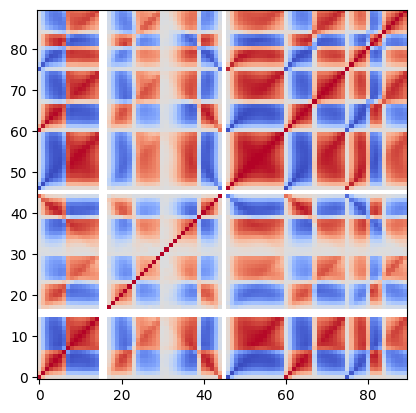

In [133]:
plt.imshow(cov, origin="lower", cmap="coolwarm")

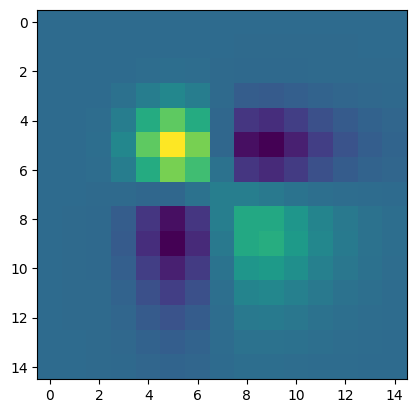

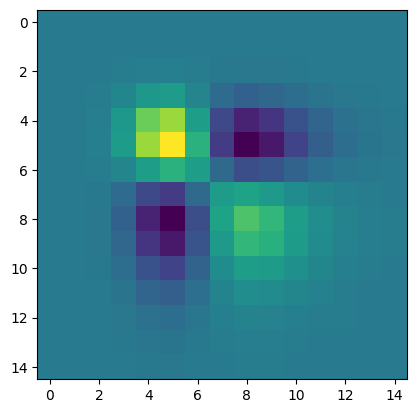

In [62]:
from matplotlib import pyplot as plt

plt.imshow(merged_stats_tiled[2.0][0][2]["v1"]["cov"])
plt.show()

plt.imshow(merged_stats_tiled[2.0][0][2]["pdf"]["cov"])
plt.show()